In [8]:
import torch as th
import torch.nn as nn
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

if th.cuda.is_available():
    print('CUDA is available')
device = th.device("cuda:0")
th.set_default_tensor_type('torch.cuda.FloatTensor')
th.set_default_dtype(th.float32)
d = 4

th.set_grad_enabled(False)

m_V = 512; n_V = 2
m_ctrl = 1024; n_ctrl = 2

class CustomNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, L):
        super(CustomNeuralNetwork, self).__init__()
        self.L = L
        self.sigmoid = nn.Sigmoid()
        
        self.W1 = nn.Linear(input_size, hidden_size)
        self.Uz = nn.ModuleList([nn.Linear(input_size, hidden_size) for _ in range(L)])
        self.Wz = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(L)])
        self.Ug = nn.ModuleList([nn.Linear(input_size, hidden_size) for _ in range(L)])
        self.Wg = nn.Linear(hidden_size, hidden_size)
        self.Ur = nn.ModuleList([nn.Linear(input_size, hidden_size) for _ in range(L)])
        self.Wr = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(L)])
        self.Uh = nn.ModuleList([nn.Linear(input_size, hidden_size) for _ in range(L)])
        self.Wh = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(L)])
        
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        S = self.sigmoid(self.W1(x))
        for l in range(self.L):
            Z = self.sigmoid(self.Uz[l](x) + self.Wz[l](S))
            G = self.sigmoid(self.Ug[l](x) + self.Wg(S))
            R = self.sigmoid(self.Ur[l](x) + self.Wr[l](S))
            H = self.sigmoid(self.Uh[l](x) + self.Wh[l](S * R))
            S = (1 - G) * H + Z * S
        
        out = self.output(S)
        return out
    
neural_V = CustomNeuralNetwork(d, m_V, 1, n_V)
naive_V = CustomNeuralNetwork(d, m_V, 1, n_V)
CE_V = CustomNeuralNetwork(d, m_V, 1, n_V)

neural_ctrl = th.nn.Sequential()
neural_ctrl.add_module('linear'+str(0), th.nn.Linear(d, m_ctrl))
neural_ctrl.add_module('Sigmoid'+str(0), th.nn.Sigmoid())
for i in range(1,n_ctrl):
    neural_ctrl.add_module('linear'+str(i), th.nn.Linear(m_ctrl,m_ctrl))
    neural_ctrl.add_module('Sigmoid'+str(i), th.nn.Sigmoid())
neural_ctrl.add_module('linear'+str(n_ctrl), th.nn.Linear(m_ctrl, 1))

y_min = -3; y_max = 3; m_min = -5.0; m_max = 5.0; g_min = 0.0; g_max = 10.0
y0 = 0; T = 1; sig = 1; c = 2; rho = 2; C = 5
        
neural_V.load_state_dict(th.load('outputs/neural_V.pt'))
neural_ctrl.load_state_dict(th.load('outputs/neural_ctrl.pt'))
naive_V.load_state_dict(th.load('outputs/neural_V_naive.pt'))
CE_V.load_state_dict(th.load('outputs/neural_V_CE.pt'))

neural_V.eval()
neural_ctrl.eval()
naive_V.eval()
CE_V.eval()

CUDA is available


In [9]:
# Transfer everything to CPU and set as default from here on
neural_V.to('cpu')
neural_ctrl.to('cpu')
naive_V.to('cpu')
CE_V.to('cpu')
device = th.device('cpu')
th.set_default_tensor_type('torch.FloatTensor')

In [30]:
dl = 1.0e-4 # Resolution of the integral

def density(l): # lambda ~ U(0,1)
    return 1

def F(x, l):
    return th.exp(l*x[:,0]-0.5*l**2*x[:,1]) * density(l)

def F_m(x, l):
    return l*th.exp(l*x[:,0]-0.5*l**2*x[:,1]) * density(l)

def F_mm(x, l):
    return l**2*th.exp(l*x[:,0]-0.5*l**2*x[:,1]) * density(l)

def G(x):
    l = th.arange(0, 1, dl)
    integral1 = th.trapezoid(F_m(x.unsqueeze(-1), l), l)
    integral2 = th.trapezoid(F(x.unsqueeze(-1), l), l)
    return integral1 / integral2

def G_m(x):
    l = th.arange(0, 1, dl)
    integral1 = th.trapezoid(F_mm(x.unsqueeze(-1), l), l)
    integral2 = th.trapezoid(F(x.unsqueeze(-1), l), l)
    return integral1 / integral2 - G(x) ** 2

def f(x, u, lam):
    G_out = G(x[:,2:4]).unsqueeze(-1)
    return th.stack((th.ones(x[:,2].shape).unsqueeze(-1), lam * u, (1/sig**2) * G_out * u ** 2, (1/sig**2) * u ** 2, c * x[:,1].unsqueeze(-1) ** 2 + rho * u ** 2), dim=1).squeeze()

def sigma(x,u):
    zeros = th.zeros((x[:,2].shape[0],1))
    return th.stack((zeros, sig * th.ones((x[:,2].shape[0],1)), (1/sig**2) * u, zeros, zeros), dim=1).squeeze()

def terminal(x):
    return C * x[:,1] ** 2 

Riccati_Solution = th.load('outputs/FD_Riccati.pt').to(device)
dt_Riccati = 1.0e-4
dlambda_Riccati  = 1.0e-4

def Riccati(t, l):
    index_lam = th.floor_divide(l, dlambda_Riccati ).int()
    index_t = th.floor_divide(t, dt_Riccati ).int()
    return Riccati_Solution[index_lam, index_t]

def u_LQR(x, lam):
    return -(lam / rho) * Riccati(x[:, 0], lam) * x[:, 1]

def solve_SDE(x0, T, dt, u, dW, lam, naive_lam):
    with th.no_grad():
        M = dW.shape[0]
    
        X = th.zeros((M, int(T/dt), d+1)); X[:,0,:] = x0.clone().permute(-1)
        X_unctrld = th.zeros((M, int(T/dt), d+1)); X_unctrld[:,0,:] = x0.clone().permute(-1)
        X_naive = th.zeros((M, int(T/dt), d+1)); X_naive[:,0,:] = x0.clone().permute(-1)
        X_CE = th.zeros((M, int(T/dt), d+1)); X_CE[:,0,:] = x0.clone().permute(-1)
        
        ctrl_eval = th.zeros((M, int(T/dt), 1))
        ctrl_eval_naive = th.zeros((M, int(T/dt), 1))
        ctrl_eval_CE = th.zeros((M, int(T/dt), 1))
        
        G_out = th.zeros((M, int(T/dt), 1))
        lam = lam.repeat(M,1)
        
        for i in range(1,int(T/dt)):
            x = X[:,i-1,:].clone()
            x_unctrld = X_unctrld[:,i-1,:].clone()
            x_naive = X_naive[:,i-1,:].clone()
            x_CE = X_CE[:,i-1,:].clone()
            
            u_out = u(x[:,0:4]).squeeze(0)
            u_naive = u_LQR(x_naive, naive_lam).unsqueeze(-1)
            u_CE = u_LQR(x_CE, G(x_CE[:,2:4])).unsqueeze(-1)
            
            ctrl_eval[:,i,:] = u_out
            ctrl_eval_naive[:,i,:] = u_naive
            ctrl_eval_CE[:,i,:] = u_CE
            
            X[:,i,:] = x + f(x, u_out, lam) * dt + sigma(x, u_out) * dW[:,i-1,:] * th.sqrt(dt)
            X_unctrld[:,i,:] = x_unctrld + f(x_unctrld, th.zeros_like(u_out), lam) * dt + sigma(x_unctrld,th.zeros_like(u_out)) * dW[:,i-1,:] * th.sqrt(dt)
            X_naive[:,i,:] = x_naive + f(x_naive, u_naive, lam) * dt + sigma(x_naive, u_naive) * dW[:,i-1,:] * th.sqrt(dt)
            X_CE [:,i,:] = x_CE + f(x_CE, u_CE, lam) * dt + sigma(x_CE, u_CE) * dW[:,i-1,:] * th.sqrt(dt)
            
            G_out[:,i,:] = G(x[:,2:4]).unsqueeze(-1)
    return X, X_unctrld, X_naive, X_CE, ctrl_eval, ctrl_eval_naive, ctrl_eval_CE, G_out

In [11]:
x0 = th.tensor([0.0, y0, 0.0, 0.0, 0.0])
dt = th.tensor(0.01)
sample_size = (int(2))
dW = th.randn((sample_size, int(T/dt)-1, 1))
dist_lam = th.distributions.uniform.Uniform(0.0, 1.0)
lam = dist_lam.sample((1,))
naive_lam = th.tensor(0.5)

X, X_unctrld, X_naive, X_CE, ctrl_eval, ctrl_eval_naive, ctrl_eval_CE, G_out = solve_SDE(x0, T, dt, neural_ctrl, dW, lam, naive_lam)

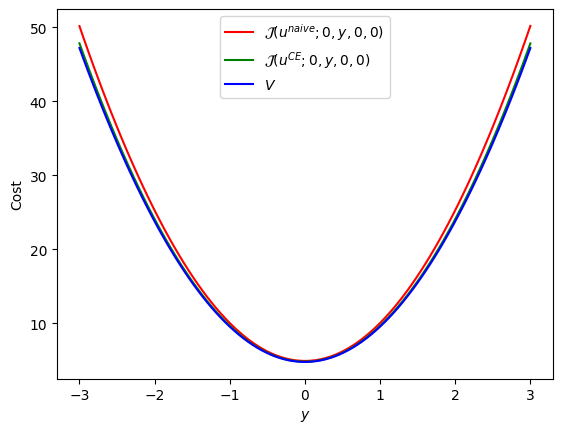

In [12]:
def eta(x):
    return (T - x[:, 0]) 

def u_composed(x, net):
    return net(x) * eta(x).unsqueeze(1) + terminal(x).unsqueeze(1)

def plot_VF_ty00_slices():
    x_range = np.linspace(0, 1, 100)
    y_range = np.linspace(-3, 3, 100)

    x_mesh, y_mesh = np.meshgrid(x_range, y_range)

    x_input = th.tensor(x_mesh.reshape(-1, 1), dtype=th.float32)
    y_input = th.tensor(y_mesh.reshape(-1, 1), dtype=th.float32)
    inputs = th.cat((x_input, y_input), dim=1)

    fixed_dim1 = th.ones(inputs.shape[0], 1) * 0.0
    fixed_dim2 = th.ones(inputs.shape[0], 1) * 0.0

    final_inputs = th.cat((inputs, fixed_dim1, fixed_dim2), dim=1)
    
    with th.no_grad():
        outputs = u_composed(final_inputs, neural_V)
        outputs2 = u_composed(final_inputs, naive_V)
        outputs3 = u_composed(final_inputs, CE_V)

    z_mesh = outputs.cpu().numpy().reshape(x_mesh.shape)
    z_mesh2 = outputs2.cpu().numpy().reshape(x_mesh.shape)
    z_mesh3 = outputs3.cpu().numpy().reshape(x_mesh.shape)
    
    z_mesh_sliced = z_mesh[:,::100]
    z_mesh2_sliced = z_mesh2[:,::100]
    z_mesh3_sliced = z_mesh3[:,::100]
    
    # Add the last column of z_mesh and z_mesh2 to z_mesh_sliced and z_mesh2_sliced
    z_mesh_sliced = np.hstack((z_mesh_sliced, z_mesh[:,-1].reshape(-1,1)))
    z_mesh2_sliced = np.hstack((z_mesh2_sliced, z_mesh2[:,-1].reshape(-1,1)))
    z_mesh3_sliced = np.hstack((z_mesh3_sliced, z_mesh3[:,-1].reshape(-1,1)))
    n = z_mesh_sliced.shape[1]
    
    plt.plot(y_range, z_mesh2_sliced[:,0], color='red')
    plt.plot(y_range, z_mesh3_sliced[:,0], color='green')
    plt.plot(y_range, z_mesh_sliced[:,0], color='blue')
    
    plt.legend(['$\mathcal{J}(u^{naive};0,y,0,0)$', '$\mathcal{J}(u^{CE};0,y,0,0)$', '$V$'])
    plt.xlabel('$y$')
    plt.ylabel('Cost')
    plt.show()
    
plot_VF_ty00_slices()

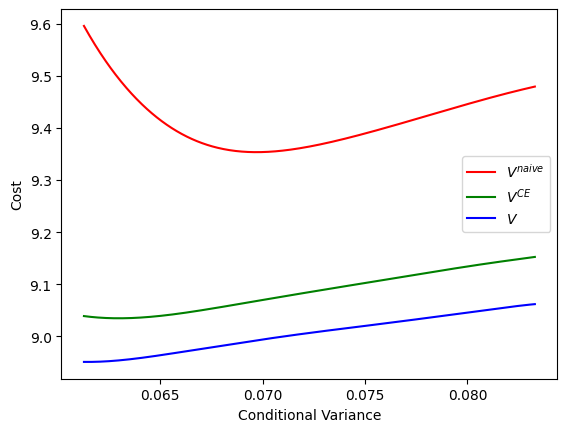

In [31]:
def VF_variance():
    number_of_samples = 1000
    m_range = th.linspace(-4.5, 4.5, number_of_samples)
    g_range = th.linspace(0, 9, number_of_samples)
    t = th.ones(m_range.shape[0] ** 2, 1) * 0.1
    y = th.ones(m_range.shape[0] ** 2, 1) * 1.0
    input = th.cat((t, y, th.cartesian_prod(m_range, g_range)), dim=1)

    def G_cpu(x):
        l = th.arange(0, 1, dl).cpu()
        integral1 = th.trapezoid(F_m(x.unsqueeze(-1), l), l)
        integral2 = th.trapezoid(F(x.unsqueeze(-1), l), l)
        return integral1 / integral2
    
    def G_m_cpu(x):
        l = th.arange(0, 1, dl).cpu()
        integral1 = th.trapezoid(F_mm(x.unsqueeze(-1), l), l)
        integral2 = th.trapezoid(F(x.unsqueeze(-1), l), l)
        return integral1 / integral2 - G_cpu(x) ** 2
    
    cond_var = G_m_cpu(input[:,2:4].cpu()).to(device)
    cond_mean = G_cpu(input[:,2:4].cpu()).to(device)
    bound = 1.0e-4
    fixed_mean = 0.50
    
    selected_inputs = input[th.abs(cond_mean - fixed_mean) < bound]
    sorted_inputs = selected_inputs[th.argsort(G_m(selected_inputs[:,2:4]))]
    
    with th.no_grad():
        out_epsilon = u_composed(sorted_inputs, neural_V)
        out_naive = u_composed(sorted_inputs, naive_V)
        out_CE = u_composed(sorted_inputs, CE_V)
    
    sorted_cond_var = G_m(sorted_inputs[:,2:4]).cpu().detach().numpy()
    
    plt.plot(sorted_cond_var, out_naive, label='$V^{naive}$', color='red')
    plt.plot(sorted_cond_var, out_CE, label='$V^{CE}$', color='green')
    plt.plot(sorted_cond_var, out_epsilon, label='$V$', color='blue')
    
    plt.xlabel('Conditional Variance')
    plt.ylabel('Cost')

    plt.legend()
    plt.show()

VF_variance()

[0.3487794  0.34913513 0.34921643 ... 0.65068376 0.6507649  0.65112054]


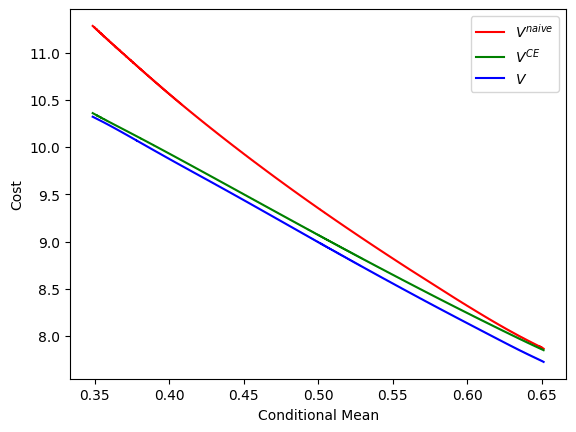

In [14]:
def VF_mean():
    number_of_samples = 1000
    m_range = th.linspace(-4.5, 4.5, number_of_samples)
    g_range = th.linspace(0, 9, number_of_samples)
    t = th.ones(m_range.shape[0] ** 2, 1) * 0.1
    y = th.ones(m_range.shape[0] ** 2, 1) * 1.0
    input = th.cat((t, y, th.cartesian_prod(m_range, g_range)), dim=1)
    

    def G_cpu(x):
        l = th.arange(0, 1, dl).cpu()
        integral1 = th.trapezoid(F_m(x.unsqueeze(-1), l), l)
        integral2 = th.trapezoid(F(x.unsqueeze(-1), l), l)
        return integral1 / integral2
    
    def G_m_cpu(x):
        l = th.arange(0, 1, dl).cpu()
        integral1 = th.trapezoid(F_mm(x.unsqueeze(-1), l), l)
        integral2 = th.trapezoid(F(x.unsqueeze(-1), l), l)
        return integral1 / integral2 - G_cpu(x) ** 2
    
    cond_var = G_m_cpu(input[:,2:4].cpu()).to(device)
    cond_mean = G_cpu(input[:,2:4].cpu()).to(device)
    bound = 1.0e-4
    fixed_var = 0.07
    
    selected_inputs = input[th.abs(cond_var - fixed_var) < bound]
    sorted_inputs = selected_inputs[th.argsort(G(selected_inputs[:,2:4]))]
    
    with th.no_grad():
        out_epsilon = u_composed(sorted_inputs, neural_V)
        out_naive = u_composed(sorted_inputs, naive_V)
        out_CE = u_composed(sorted_inputs, CE_V)
    
    sorted_cond_mean = G(sorted_inputs[:,2:4]).cpu().detach().numpy()
    
    plt.plot(sorted_cond_mean, out_naive, label='$V^{naive}$', color='red')
    plt.plot(sorted_cond_mean, out_CE, label='$V^{CE}$', color='green')
    plt.plot(sorted_cond_mean, out_epsilon, label='$V$', color='blue')
    
    plt.xlabel('Conditional Mean')
    plt.ylabel('Cost')

    plt.legend()
    plt.show()

VF_mean()